In [67]:
import pandas as pd
import numpy as np
import os
import pickle
from copy import deepcopy
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, r2_score
from data_loader import get_identifier
import matplotlib.pyplot as plt

def read_validation_additional_lines_labels(file_path='additional_lines_labels.csv'):
    df = pd.read_csv(file_path, index_col=0, dtype='str')
    df.index = [tuple(n.split('_')) for n in df.index]
    mapping = {'0': 0.,
               '0*': 0.,
               '0(0.5)': 0.2,
               '0(1)': 0.4,
               '0/1': 0.4,
               '0(1.5)': 0.6,
               '0(1.5/2)': 0.8,
               '0(2)': 0.8,
               '0(2)*': 0.8,
               '1': 1.,
               '1*': 1.,
               'nan': np.nan,
               '-': np.nan}
    for col in df:
        values = [mapping[v] if v == v else np.nan for v in df[col]]
        df[col] = values
    return df


def generate_label_for_3R(name_file, classify_label_file):
    names = pickle.load(open(name_file, 'rb'))
    labels = pickle.load(open(classify_label_file, 'rb'))
    assert len(set([get_identifier(names[i])[:2] for i in names])) == 1
    wells = [get_identifier(names[i])[-2:] for i in names]
    label_dict = {}
    for w in set(wells):
        inds = [i for i in names if get_identifier(names[i])[-2:] == w]
        inds = sorted(inds, key=lambda x: -int(get_identifier(names[x])[2]))
        well_label = [labels[i] for i in inds if labels[i][1] > 0]
        if len(well_label) == 0:
            continue
        l = well_label[0][0]
        if isinstance(l, np.ndarray) and l.size == 4:
            l = (l[1] + l[2] * 2 + l[3] * 3)/3
        label_dict[w] = l
    return label_dict


def evaluate_confmat(y_trues, y_preds, soft=True):
    conf_mat = np.zeros((6, 4))
    for y_true, y_pred in zip(y_trues, y_preds):
        label = int(np.round(y_true * 5))
        if soft:
            conf_mat[label] += y_pred.reshape((4,))
        else:
            conf_mat[label, np.argmax(y_pred)] += 1
    conf_mat = conf_mat / conf_mat.sum(1, keepdims=True)
    return conf_mat
    

def evaluate_binary_metric(y_trues, y_preds, cutoff=1):
    _y_preds = y_preds[:, cutoff:].sum(1)
    _y_trues = y_trues
    
    pos_rate = sum(_y_trues) / len(_y_trues)
    
    s1 = precision_score(_y_trues, _y_preds > 0.5)
    s2 = recall_score(_y_trues, _y_preds > 0.5)
    s3 = f1_score(_y_trues, _y_preds > 0.5)
    s4 = roc_auc_score(_y_trues, _y_preds)
    print("N-samples: %d\tPos rate: %.3f\tPrec: %.3f\tRecall: %.3f\tF1: %.3f\tAUC: %.3f" % \
          (len(_y_trues), pos_rate, s1, s2, s3, s4))
    return s1, s2, s3, s4


def plot_roc_auc_curves(roc_auc_curves, plot_median=False, markersize=7, linewidth=1.0):
    for line, curve in roc_auc_curves.items():
        x = sorted(curve.keys())
        y = [curve[_x] for _x in x]
        plt.plot(x, y, '.--', label=line, markersize=markersize, linewidth=linewidth)
    
    if plot_median:
        x = sorted(set().union(*[curve.keys() for curve in roc_auc_curves.values()]))
        median_line = [np.nanmedian([curve[_x] if _x in curve else np.nan for curve in roc_auc_curves.values()]) for _x in x]
        plt.plot(x, median_line, '*-', color='k', label='Median', markersize=2*markersize, linewidth=2*linewidth)

    plt.legend(ncol=2)
    plt.ylim(0.4, 1.01)
    plt.xlabel("Input Phase Contrast Day")
    plt.ylabel("ROC-AUC")


def plot_roc_auc_box(roc_auc_curves, start=4, end=10):
    scores_by_day = {}
    for line, curve in roc_auc_curves.items():
        x = sorted(curve.keys())
        for _x in x:
            if not _x in scores_by_day:
                scores_by_day[_x] = []
            scores_by_day[_x].append(curve[_x])
    plt.boxplot([scores_by_day[x] for x in np.arange(start, end+1)], positions=np.arange(start, end+1))
    plt.ylim(0.4, 1.01)
    plt.xlabel("Input Phase Contrast Day")
    plt.ylabel("ROC-AUC")


def boxplot_pred_distri(pred_val_df, 
                        label_cutoff=0.5,
                        exclude_ambiguous=False, 
                        boxplot_fig_output=None,
                        samplect_fig_output=None):
    _y_preds = []
    _y_trues = []
    properties = []
    for col in pred_val_df:
        if col.endswith('pred'):
            day = int(col.split('_')[0][1:])
            _p = np.array(pred_val_df[col])
            _l = np.array(pred_val_df['label'])
            inds = np.where((_p == _p) * (_l == _l))[0]
            if exclude_ambiguous:
                inds = np.where((_p == _p) * (_l == np.round(_l)))[0]
            _y_preds.append(_p[inds])
            _y_trues.append(_l[inds])
            properties.append([day] * len(inds))
            
    _y_preds = np.concatenate(_y_preds)
    _y_trues = (np.concatenate(_y_trues) > label_cutoff) * 1
    properties = np.concatenate(properties)

    x_axis = sorted(set(properties))

    pred_neg = {i: [] for i in x_axis}
    pred_pos = {i: [] for i in x_axis}
    for pred, label, prop in zip(_y_preds, _y_trues, properties):
        if label == 0:
            pred_neg[prop].append(pred)
        elif label == 1:
            pred_pos[prop].append(pred)
        else:
            raise ValueError

    plt.clf()
    fig, ax = plt.subplots(figsize=(7, 3))
    red_diamond = dict(markerfacecolor='r', marker='D', markersize=2)
    data = [pred_pos[_x] for _x in x_axis]
    bplot_pos = ax.boxplot(
        data,
        notch=True,
        vert=True,
        patch_artist=True,
        positions=np.arange(len(x_axis))+0.11,
        flierprops=red_diamond,
        widths=0.2,
        manage_ticks=False)
    blue_diamond = dict(markerfacecolor='b', marker='D', markersize=2)
    data = [pred_neg[_x] for _x in x_axis]
    bplot_neg = ax.boxplot(
        data,
        notch=True,
        vert=True,
        patch_artist=True,
        positions=np.arange(len(x_axis))-0.11,
        flierprops=blue_diamond,
        widths=0.2,
        manage_ticks=False)
    ax.set_xticks(np.arange(len(x_axis)))
    ax.set_xticklabels(x_axis)
    ax.set_xlim(-1, len(x_axis))
    ax.set_ylim([-0.03, 1.03])
    for patch in bplot_pos['boxes']:
        patch.set_facecolor('pink')
    for patch in bplot_neg['boxes']:
        patch.set_facecolor('lightblue')
    ax.set_title('Prediction Distribution')
    if not boxplot_fig_output is None:
        plt.savefig(boxplot_fig_output, dpi=300, bbox_inches='tight')
    else:
        plt.show()

    plt.clf()
    fig, ax = plt.subplots(figsize=(7, 1.5))
    ax.plot(np.arange(len(x_axis)), [len(pred_pos[_x]) for _x in x_axis], c='pink')
    ax.plot(np.arange(len(x_axis)), [len(pred_neg[_x]) for _x in x_axis], c='lightblue')
    ax.set_xticks(np.arange(len(x_axis)))
    ax.set_xticklabels(x_axis)
    ax.set_xlim(-1, len(x_axis))
    ax.set_ylim([0, ax.get_ylim()[1]])
    if not samplect_fig_output is None:
        plt.savefig(samplect_fig_output, dpi=300, bbox_inches='tight')
    else:
        plt.show()


    
def load_cla_pred_as_dict(path):
    pred_file = os.path.join(path, 'cla.pkl')
    preds = pickle.load(open(pred_file, 'rb'))
    pred_dict = dict(zip([get_identifier(n) for n in preds['pred_names']], preds['cla_preds']))
    return pred_dict


def report_series_accuracy(pred_dicts, 
                           label_dict, 
                           exclude_ambiguous=False, 
                           start=4,
                           end=10,
                           pred_cutoff=2, 
                           label_cutoff=0.5):
    
    label_ks = sorted(label_dict.keys())
    pred_val_df = pd.DataFrame({'label': [label_dict[k] for k in label_ks]})
    pred_val_df.index = label_ks
    
    curve = {}
    for day in np.arange(start, end+1):
        _pred_dicts = [{k[-2:]: v for k, v in pd.items() if int(k[2]) == day} for pd in pred_dicts]
        shared_keys = sorted(set(_pred_dicts[0].keys()) & set(label_dict.keys()))
        shared_keys = [k for k in shared_keys if label_dict[k] == label_dict[k]]
        if exclude_ambiguous:
            shared_keys = [k for k in shared_keys if np.round(label_dict[k]) == label_dict[k]]
        if len(shared_keys) > 10:
            y_trues = np.array([label_dict[k] for k in shared_keys]) > label_cutoff
            y_preds = np.stack([np.stack([pd[k] for k in shared_keys], 0) for pd in _pred_dicts], 0).mean(0)
            res = evaluate_binary_metric(y_trues, y_preds, cutoff=pred_cutoff)
            curve[int(day)] = res[-1]
            pred_val_df['D%d_pred' % day] = [np.mean([pd[k][pred_cutoff:].sum() for pd in _pred_dicts]) if k in _pred_dicts[0] else np.nan for k in label_ks]

    return curve, pred_val_df


def combine_multi_line_preds(pred_val_dfs, 
                             label_cutoff=0.5,
                             start=4,
                             end=10,):
    combined_df = []
    all_columns = set().union(*[pred_val_df.columns for pred_val_df in pred_val_dfs.values()])
    for k, pred_val_df in pred_val_dfs.items():
        pred_val_df = deepcopy(pred_val_df)
        pred_val_df.index = [(k, p) for p in pred_val_df.index]
        for c in all_columns:
            if not c in pred_val_df:
                pred_val_df[c] = [np.nan for _ in range(pred_val_df.shape[0])]
        combined_df.append(pred_val_df)

    combined_df = pd.concat(combined_df)
    curve = {}
    for day in np.arange(start, end+1):
        label = np.array(combined_df['label']).flatten()
        pred = np.array(combined_df['D%d_pred' % day]).flatten()
        
        valid_inds = np.where((label == np.round(label)) * (pred == pred))[0]
        res = roc_auc_score(label[valid_inds] > label_cutoff, pred[valid_inds])
        curve[day] = res
    return curve, combined_df
        
        

3R
N-samples: 924	Pos rate: 0.451	Prec: 0.696	Recall: 0.710	F1: 0.703	AUC: 0.804
N-samples: 924	Pos rate: 0.451	Prec: 0.684	Recall: 0.746	F1: 0.713	AUC: 0.822
N-samples: 924	Pos rate: 0.451	Prec: 0.685	Recall: 0.772	F1: 0.726	AUC: 0.851
N-samples: 924	Pos rate: 0.451	Prec: 0.828	Recall: 0.760	F1: 0.793	AUC: 0.913
N-samples: 924	Pos rate: 0.451	Prec: 0.985	Recall: 0.765	F1: 0.861	AUC: 0.954
839
N-samples: 504	Pos rate: 0.478	Prec: 0.569	Recall: 0.324	F1: 0.413	AUC: 0.503
N-samples: 504	Pos rate: 0.478	Prec: 0.768	Recall: 0.647	F1: 0.703	AUC: 0.815
N-samples: 504	Pos rate: 0.478	Prec: 0.861	Recall: 0.643	F1: 0.736	AUC: 0.851
N-samples: 504	Pos rate: 0.478	Prec: 0.886	Recall: 0.548	F1: 0.677	AUC: 0.839
975
N-samples: 256	Pos rate: 0.754	Prec: 0.699	Recall: 0.301	F1: 0.420	AUC: 0.430
N-samples: 256	Pos rate: 0.754	Prec: 0.925	Recall: 0.762	F1: 0.835	AUC: 0.845
N-samples: 256	Pos rate: 0.754	Prec: 0.912	Recall: 0.912	F1: 0.912	AUC: 0.899
N-samples: 256	Pos rate: 0.754	Prec: 0.938	Recall: 0.

<Figure size 432x288 with 0 Axes>

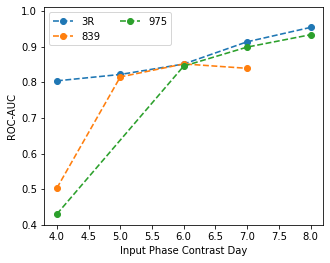

In [427]:
### Different wells - 12 well ###
line_paths = [
    'VALIDATION/different_wells/12well/line1_3R/ex2-12well/',
    'VALIDATION/different_wells/12well/line_839/ex0/',
    'VALIDATION/different_wells/12well/line_975/ex0/',
]

pred_file_names = [
    #'ex-valid-pred-to-17',
    'ex-test-pred-to-17',
    'ex-test-pred-to-18',
]

exclude_ambiguous = [False, True, True]

label_cutoff = 0.5
pred_cutoff = 2

### prepare labels ###
# label_path = 'VALIDATION/different_wells/12well/raw_labels.csv'
# label_df = read_validation_additional_lines_labels(file_path=label_path)
# label_df.index = [(p[0], p[3]) for p in label_df.index]
# _3R_labels = generate_label_for_3R('VALIDATION/different_wells/12well/line1_3R/ex2-12well/names.pkl',
#                                    'VALIDATION/different_wells/12well/line1_3R/ex2-12well/classify_continuous_labels.pkl')
# label_df['3R'] = [_3R_labels[k] if k in _3R_labels else np.nan for k in label_df.index]
# label_df.to_csv('VALIDATION/different_wells/12well/labels.csv')
###

label_path = 'VALIDATION/different_wells/12well/labels.csv'
label_df = pd.read_csv(label_path, index_col=0)
label_df.index = [eval(p) for p in label_df.index]

roc_auc_curves = {}
pred_val_dfs = {}
for i_line, line in enumerate(line_paths):
    line_name = get_identifier(line)[0].split('_')[1]
    print(line_name)
    label_dict = dict(zip(label_df.index, label_df[line_name]))
    pred_dicts = [load_cla_pred_as_dict(os.path.join(line, pred_file_name)) for pred_file_name in pred_file_names]
    
    auc_curve, pred_val_df = report_series_accuracy(pred_dicts, 
                                                    label_dict, 
                                                    exclude_ambiguous=exclude_ambiguous[i_line], 
                                                    pred_cutoff=pred_cutoff,
                                                    label_cutoff=label_cutoff,
                                                    start=4,
                                                    end=8)
    
    roc_auc_curves[line_name] = auc_curve
    pred_val_dfs[line_name] = pred_val_df


plt.clf()
plt.figure(figsize=(5, 4))
plot_roc_auc_curves(roc_auc_curves, plot_median=False, markersize=12, linewidth=1.6)
plt.show()

3R
N-samples: 594	Pos rate: 0.037	Prec: 0.094	Recall: 0.364	F1: 0.150	AUC: 0.652
N-samples: 594	Pos rate: 0.037	Prec: 0.109	Recall: 0.682	F1: 0.187	AUC: 0.809
N-samples: 594	Pos rate: 0.037	Prec: 0.059	Recall: 0.591	F1: 0.108	AUC: 0.721
N-samples: 594	Pos rate: 0.037	Prec: 0.102	Recall: 0.636	F1: 0.176	AUC: 0.823
N-samples: 594	Pos rate: 0.037	Prec: 0.234	Recall: 0.682	F1: 0.349	AUC: 0.940
975-839
N-samples: 279	Pos rate: 0.756	Prec: 0.886	Recall: 0.664	F1: 0.759	AUC: 0.743
N-samples: 279	Pos rate: 0.756	Prec: 0.920	Recall: 0.758	F1: 0.831	AUC: 0.847
N-samples: 279	Pos rate: 0.756	Prec: 0.968	Recall: 0.711	F1: 0.820	AUC: 0.884
N-samples: 279	Pos rate: 0.756	Prec: 0.953	Recall: 0.763	F1: 0.847	AUC: 0.872
N-samples: 279	Pos rate: 0.756	Prec: 0.973	Recall: 0.692	F1: 0.809	AUC: 0.896


<Figure size 432x288 with 0 Axes>

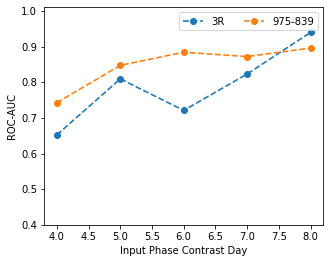

In [428]:
### Different wells - 24 well ###
line_paths = [
    'VALIDATION/different_wells/24well/line1_3R/ex0-24well/',
    'VALIDATION/different_wells/24well/line_975-839/ex0/',
]

pred_file_names = [
    #'ex-valid-pred-to-17',
    'ex-test-pred-to-17',
    'ex-test-pred-to-18',
]

exclude_ambiguous = [False, True]

label_cutoff = 0.5
pred_cutoff = 2

### prepare labels ###
# label_path = 'VALIDATION/different_wells/24well/raw_labels.csv'
# label_df = read_validation_additional_lines_labels(file_path=label_path)
# label_df.index = [(p[0], p[3]) for p in label_df.index]
# _3R_labels = generate_label_for_3R('VALIDATION/different_wells/24well/line1_3R/ex0-24well/names.pkl',
#                                    'VALIDATION/different_wells/24well/line1_3R/ex0-24well/classify_continuous_labels.pkl')
# label_df['3R'] = [_3R_labels[k] if k in _3R_labels else np.nan for k in label_df.index]
# label_df.to_csv('VALIDATION/different_wells/24well/labels.csv')
###

label_path = 'VALIDATION/different_wells/24well/labels.csv'
label_df = pd.read_csv(label_path, index_col=0)
label_df.index = [eval(p) for p in label_df.index]

roc_auc_curves = {}
pred_val_dfs = {}
for i_line, line in enumerate(line_paths):
    line_name = get_identifier(line)[0].split('_')[1]
    print(line_name)
    label_dict = dict(zip(label_df.index, label_df[line_name]))
    pred_dicts = [load_cla_pred_as_dict(os.path.join(line, pred_file_name)) for pred_file_name in pred_file_names]
    
    auc_curve, pred_val_df = report_series_accuracy(pred_dicts, 
                                                    label_dict, 
                                                    exclude_ambiguous=exclude_ambiguous[i_line], 
                                                    pred_cutoff=pred_cutoff,
                                                    label_cutoff=label_cutoff,
                                                    start=4,
                                                    end=8)
    roc_auc_curves[line_name] = auc_curve
    pred_val_dfs[line_name] = pred_val_df

plt.clf()
plt.figure(figsize=(5, 4))
plot_roc_auc_curves(roc_auc_curves, plot_median=False, markersize=12, linewidth=1.6)
plt.show()

3R
N-samples: 920	Pos rate: 0.342	Prec: 0.700	Recall: 0.771	F1: 0.734	AUC: 0.895
N-samples: 920	Pos rate: 0.342	Prec: 0.592	Recall: 0.886	F1: 0.710	AUC: 0.874
N-samples: 920	Pos rate: 0.342	Prec: 0.761	Recall: 0.476	F1: 0.586	AUC: 0.805
N-samples: 920	Pos rate: 0.342	Prec: 0.788	Recall: 0.686	F1: 0.733	AUC: 0.895
N-samples: 920	Pos rate: 0.342	Prec: 0.706	Recall: 0.768	F1: 0.736	AUC: 0.901
839
N-samples: 362	Pos rate: 0.343	Prec: 0.363	Recall: 0.766	F1: 0.492	AUC: 0.497
N-samples: 362	Pos rate: 0.343	Prec: 0.547	Recall: 0.750	F1: 0.633	AUC: 0.777
N-samples: 362	Pos rate: 0.343	Prec: 0.839	Recall: 0.839	F1: 0.839	AUC: 0.959
N-samples: 362	Pos rate: 0.343	Prec: 0.949	Recall: 0.750	F1: 0.838	AUC: 0.972
N-samples: 362	Pos rate: 0.343	Prec: 0.936	Recall: 0.823	F1: 0.876	AUC: 0.971


<Figure size 432x288 with 0 Axes>

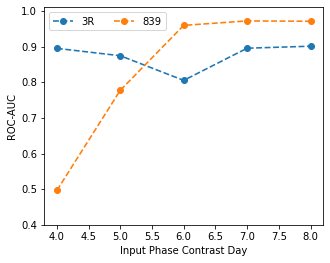

In [429]:
### Different differentiation protocol ###
line_paths = [
    'VALIDATION/different_differentiation/line1_3R/ex0/',
    'VALIDATION/different_differentiation/line_839/ex0/',
#     'VALIDATION/different_differentiation/line_975/ex0/',
]

pred_file_names = [
    #'ex-valid-pred-to-17',
    'ex-test-pred-to-17',
    'ex-test-pred-to-18',
]

exclude_ambiguous = [False, True, False]

label_cutoff = 0.5
pred_cutoff = 2

### prepare labels ###
# label_path = 'VALIDATION/different_differentiation/raw_labels.csv'
# label_df = read_validation_additional_lines_labels(file_path=label_path)
# _3R_labels = generate_label_for_3R('VALIDATION/different_differentiation/line1_3R/ex0/names.pkl',
#                                    'VALIDATION/different_differentiation/line1_3R/ex0/classify_continuous_labels.pkl')
# label_df['3R'] = [_3R_labels[k] if k in _3R_labels else np.nan for k in label_df.index]
# label_df.to_csv('VALIDATION/different_differentiation/labels.csv')
###

label_path = 'VALIDATION/different_differentiation/labels.csv'
label_df = pd.read_csv(label_path, index_col=0)
label_df.index = [eval(p) for p in label_df.index]

roc_auc_curves = {}
pred_val_dfs = {}
for i_line, line in enumerate(line_paths):
    line_name = get_identifier(line)[0].split('_')[1]
    print(line_name)
    label_dict = dict(zip(label_df.index, label_df[line_name]))
    pred_dicts = [load_cla_pred_as_dict(os.path.join(line, pred_file_name)) for pred_file_name in pred_file_names]
    
    auc_curve, pred_val_df = report_series_accuracy(pred_dicts, 
                                                    label_dict, 
                                                    exclude_ambiguous=exclude_ambiguous[i_line], 
                                                    pred_cutoff=pred_cutoff,
                                                    label_cutoff=label_cutoff,
                                                    start=4,
                                                    end=8)
    roc_auc_curves[line_name] = auc_curve
    pred_val_dfs[line_name] = pred_val_df

plt.clf()
plt.figure(figsize=(5, 4))
plot_roc_auc_curves(roc_auc_curves, plot_median=False, markersize=12, linewidth=1.6)
plt.show()


477
N-samples: 1081	Pos rate: 0.508	Prec: 0.528	Recall: 0.852	F1: 0.652	AUC: 0.649
N-samples: 1081	Pos rate: 0.508	Prec: 0.550	Recall: 0.807	F1: 0.654	AUC: 0.661
N-samples: 1081	Pos rate: 0.508	Prec: 0.828	Recall: 0.361	F1: 0.503	AUC: 0.777
N-samples: 1081	Pos rate: 0.508	Prec: 0.973	Recall: 0.732	F1: 0.836	AUC: 0.967
N-samples: 1081	Pos rate: 0.508	Prec: 0.989	Recall: 0.847	F1: 0.913	AUC: 0.980
N-samples: 1081	Pos rate: 0.508	Prec: 0.996	Recall: 0.965	F1: 0.981	AUC: 0.998
N-samples: 1081	Pos rate: 0.508	Prec: 0.993	Recall: 0.989	F1: 0.991	AUC: 1.000
202
N-samples: 856	Pos rate: 0.395	Prec: 0.422	Recall: 0.648	F1: 0.511	AUC: 0.522
N-samples: 856	Pos rate: 0.395	Prec: 0.441	Recall: 0.462	F1: 0.451	AUC: 0.635
N-samples: 856	Pos rate: 0.395	Prec: 0.597	Recall: 0.612	F1: 0.604	AUC: 0.745
N-samples: 856	Pos rate: 0.395	Prec: 0.972	Recall: 0.305	F1: 0.464	AUC: 0.929
N-samples: 856	Pos rate: 0.395	Prec: 0.976	Recall: 0.355	F1: 0.521	AUC: 0.955
N-samples: 856	Pos rate: 0.395	Prec: 0.947	Recall

<Figure size 432x288 with 0 Axes>

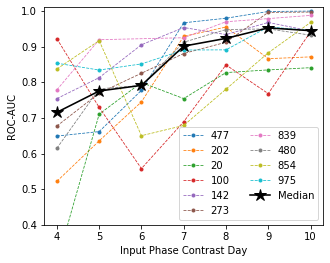

<Figure size 432x288 with 0 Axes>

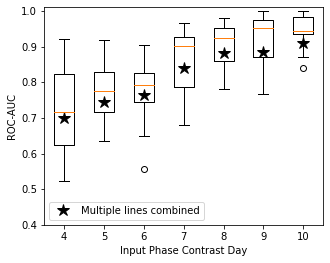

In [395]:
### 10 additional lines ###

line_paths = [
    'VALIDATION/line_477/ex0/',
    'VALIDATION/line_202/ex0/',
    'VALIDATION/line_20/ex0/',
    'VALIDATION/line_100/ex3/',
    'VALIDATION/line_142/ex1/',
    'VALIDATION/line_273/ex2/',
    'VALIDATION/line_839/ex1/',
    'VALIDATION/line_480/ex0/',
    'VALIDATION/line_854/ex0/',
    'VALIDATION/line_975/ex0/',
]

pred_file_names = [
    'ex-valid-pred-to-18',
    'ex-test-pred-to-17',
    'ex-test-pred-to-18',
]

label_df = read_validation_additional_lines_labels('VALIDATION/additional_lines_labels.csv')
label_cutoff = 0.5
pred_cutoff = 2
exclude_ambiguous = [True] * len(line_paths)

roc_auc_curves = {}
pred_val_dfs = {}
for i_line, line in enumerate(line_paths):
    line_name = get_identifier(line)[0].split('_')[1]
    print(line_name)
    label_dict = dict(zip(label_df.index, label_df[line_name]))
    pred_dicts = [load_cla_pred_as_dict(os.path.join(line, pred_file_name)) for pred_file_name in pred_file_names]
    
    auc_curve, pred_val_df = report_series_accuracy(pred_dicts, 
                                                    label_dict, 
                                                    exclude_ambiguous=exclude_ambiguous[i_line], 
                                                    pred_cutoff=pred_cutoff,
                                                    label_cutoff=label_cutoff)
    roc_auc_curves[line_name] = auc_curve
    pred_val_dfs[line_name] = pred_val_df

combined_curve, combined_df = combine_multi_line_preds(pred_val_dfs, label_cutoff=0.5)
    

plt.clf()
plt.figure(figsize=(5, 4))
plot_roc_auc_curves(roc_auc_curves, plot_median=True, markersize=6, linewidth=.8)
plt.show()

plt.clf()
plt.figure(figsize=(5, 4))
plot_roc_auc_box(roc_auc_curves, start=4, end=10)
plt.plot(sorted(combined_curve.keys()), 
         [combined_curve[k] for k in sorted(combined_curve.keys())], 
         '*', color='k', markersize=12, linewidth=1.6, label='Multiple lines combined')
plt.legend()
plt.show()

3R
N-samples: 85	Pos rate: 0.647	Prec: 0.800	Recall: 0.436	F1: 0.565	AUC: 0.738
N-samples: 85	Pos rate: 0.647	Prec: 0.870	Recall: 0.727	F1: 0.792	AUC: 0.828
N-samples: 85	Pos rate: 0.647	Prec: 0.875	Recall: 0.764	F1: 0.816	AUC: 0.853
N-samples: 85	Pos rate: 0.647	Prec: 0.909	Recall: 0.909	F1: 0.909	AUC: 0.876
N-samples: 85	Pos rate: 0.647	Prec: 0.898	Recall: 0.964	F1: 0.930	AUC: 0.904


<Figure size 432x288 with 0 Axes>

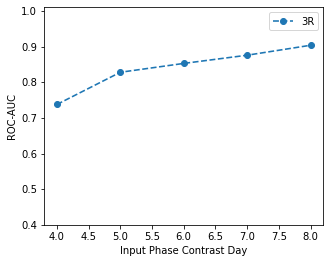

<Figure size 432x288 with 0 Axes>

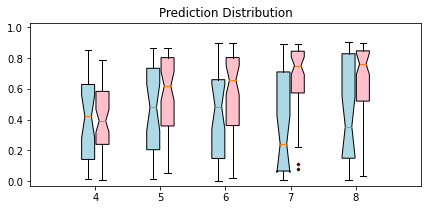

<Figure size 432x288 with 0 Axes>

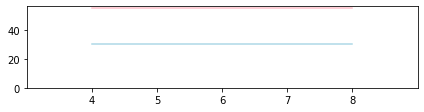

In [434]:
### Different instrument ###
line_paths = [
    'VALIDATION/line1_3R/ex2_other_instrument/',
]

pred_file_names = [
    #'ex-valid-pred-to-17',
    'ex-test-pred-to-17',
    'ex-test-pred-to-18',
]

exclude_ambiguous = [False]

label_cutoff = 0.5
pred_cutoff = 2

label_path = 'VALIDATION/line1_3R/ex2_other_instrument/other_instrument_labels.csv'
label_df = read_validation_additional_lines_labels(file_path=label_path)
label_df.columns = ['3R']
label_df.index = [(p[0], '5') for p in label_df.index]

roc_auc_curves = {}
pred_val_dfs = {}
for i_line, line in enumerate(line_paths):
    line_name = get_identifier(line)[0].split('_')[1]
    print(line_name)
    label_dict = dict(zip(label_df.index, label_df[line_name]))
    pred_dicts = [load_cla_pred_as_dict(os.path.join(line, pred_file_name)) for pred_file_name in pred_file_names]
    
    auc_curve, pred_val_df = report_series_accuracy(pred_dicts, 
                                                    label_dict, 
                                                    exclude_ambiguous=exclude_ambiguous[i_line], 
                                                    pred_cutoff=pred_cutoff,
                                                    label_cutoff=label_cutoff,
                                                    start=4,
                                                    end=8)
    roc_auc_curves[line_name] = auc_curve
    pred_val_dfs[line_name] = pred_val_df

plt.clf()
plt.figure(figsize=(5, 4))
plot_roc_auc_curves(roc_auc_curves, plot_median=False, markersize=12, linewidth=1.6)
plt.show()

boxplot_pred_distri(pred_val_dfs['3R'],
                    label_cutoff=label_cutoff,
                    boxplot_fig_output=None,
                    samplect_fig_output=None)

ex1-14
N-samples: 392	Pos rate: 0.355	Prec: 0.610	Recall: 0.360	F1: 0.452	AUC: 0.702
N-samples: 392	Pos rate: 0.355	Prec: 0.500	Recall: 0.496	F1: 0.498	AUC: 0.686
N-samples: 392	Pos rate: 0.355	Prec: 0.554	Recall: 0.626	F1: 0.588	AUC: 0.759
N-samples: 392	Pos rate: 0.355	Prec: 0.575	Recall: 0.554	F1: 0.564	AUC: 0.765
N-samples: 392	Pos rate: 0.355	Prec: 0.719	Recall: 0.295	F1: 0.418	AUC: 0.792
ex2-14
N-samples: 388	Pos rate: 0.428	Prec: 0.580	Recall: 0.548	F1: 0.563	AUC: 0.694
N-samples: 388	Pos rate: 0.428	Prec: 0.576	Recall: 0.500	F1: 0.535	AUC: 0.701
N-samples: 388	Pos rate: 0.428	Prec: 0.626	Recall: 0.687	F1: 0.655	AUC: 0.767
N-samples: 388	Pos rate: 0.428	Prec: 0.594	Recall: 0.627	F1: 0.610	AUC: 0.745
N-samples: 388	Pos rate: 0.428	Prec: 0.618	Recall: 0.645	F1: 0.631	AUC: 0.751


<Figure size 432x288 with 0 Axes>

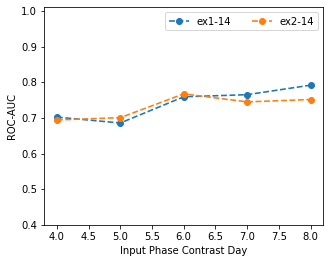

In [108]:
### Additional lines for seg (classification evaluation) ###
line_paths = [
    'VALIDATION/line_combined-for-seg/ex1-14/',
    'VALIDATION/line_combined-for-seg/ex2-14/',
]

pred_file_names = [
    #'ex-valid-pred-to-17',
    'ex-test-pred-to-17',
    'ex-test-pred-to-18',
]

exclude_ambiguous = [False, False]

label_cutoff = 0.5
pred_cutoff = 2

### prepare labels ###
# _3R_labels1 = generate_label_for_3R('VALIDATION/line_combined-for-seg/ex1-14/names.pkl',
#                                     'VALIDATION/line_combined-for-seg/ex1-14/classify_continuous_labels.pkl')
# _3R_labels2 = generate_label_for_3R('VALIDATION/line_combined-for-seg/ex2-14/names.pkl',
#                                     'VALIDATION/line_combined-for-seg/ex2-14/classify_continuous_labels.pkl')
# ks = sorted(set(_3R_labels1) | set(_3R_labels2))
# ex1_14_col = [_3R_labels1[k] if k in _3R_labels1 else np.nan for k in ks]
# ex2_14_col = [_3R_labels2[k] if k in _3R_labels2 else np.nan for k in ks]
# label_df = pd.DataFrame({'ex1-14': ex1_14_col, 'ex2-14': ex2_14_col}, index=ks)
# label_df.to_csv('VALIDATION/line_combined-for-seg/cla_labels.csv')
###

label_path = 'VALIDATION/line_combined-for-seg/cla_labels.csv'
label_df = pd.read_csv(label_path, index_col=0)
label_df.index = [eval(p) for p in label_df.index]


roc_auc_curves = {}
pred_val_dfs = {}
for i_line, line in enumerate(line_paths):
    line_name = get_identifier(line)[1]
    print(line_name)
    label_dict = dict(zip(label_df.index, label_df[line_name]))
    pred_dicts = [load_cla_pred_as_dict(os.path.join(line, pred_file_name)) for pred_file_name in pred_file_names]
    
    auc_curve, pred_val_df = report_series_accuracy(pred_dicts, 
                                                    label_dict, 
                                                    exclude_ambiguous=exclude_ambiguous[i_line], 
                                                    pred_cutoff=pred_cutoff,
                                                    label_cutoff=label_cutoff,
                                                    start=4,
                                                    end=8)
    roc_auc_curves[line_name] = auc_curve
    pred_val_dfs[line_name] = pred_val_df

plt.clf()
plt.figure(figsize=(5, 4))
plot_roc_auc_curves(roc_auc_curves, plot_median=False, markersize=12, linewidth=1.6)
plt.show()

In [ ]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['SM_FRAMEWORK'] = 'tf.keras'
import pickle
import numpy as np
import pandas as pd
import scipy
import tifffile
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, r2_score

from data_loader import get_identifier, get_ex_day
from models import Segment, ClassifyOnSegment
from layers import load_partial_weights, fill_first_layer, evaluate_confusion_mat, summarize_conf_mat
from data_generator import CustomGenerator, PairGenerator, enhance_weight_for_false_positives


def get_day(n):
    return int(get_identifier(n)[2])


def get_ind(name, gen):
    for k in gen.names:
        if gen.names[k] == name:
            return k
    return None


def get_validation_data_gen(data_root):
    name_file = os.path.join(data_root, "names.pkl")
    X_ct = len([f for f in os.listdir(data_root) if f.startswith('X_')])
    X_files = [os.path.join(data_root, "X_%d.pkl" % i) for i in range(X_ct)]

    segment_y_files = [os.path.join(data_root, "segment_continuous_y_%d.pkl" % i) for i in range(X_ct)]
    segment_w_files = [os.path.join(data_root, "segment_continuous_w_%d.pkl" % i) for i in range(X_ct)]
    classify_label_file = os.path.join(data_root, "classify_continuous_labels.pkl")
    valid_gen = CustomGenerator(
        name_file,
        X_files, 
        segment_y_files=segment_y_files, 
        segment_w_files=segment_w_files,
        n_segment_classes=4,
        segment_class_weights=[1, 1, 1, 1],
        segment_label_type='continuous',
        classify_label_file=classify_label_file,
        n_classify_classes=4,
        classify_class_weights=[1, 1, 1, 1],
        classify_label_type='continuous')
    return valid_gen


def load_cla_preds(pred_paths):
    cla_dict = {}
    for pred_path in pred_paths:
        cla_result = pickle.load(open(os.path.join(pred_path, 'cla.pkl'), 'rb'))
        for name, pred in zip(cla_result['pred_names'], cla_result['cla_preds']):
            if not name in cla_dict:
                cla_dict[name] = []
            cla_dict[name].append(pred)
    
    cla_dict = {k: np.stack(v, 0).mean(0) for k, v in cla_dict.items()}
    return cla_dict


def collect_segmentation_performance(pred_paths, valid_gen):
    if isinstance(pred_paths, str):
        pred_paths = [pred_paths]
    fs = [[f for f in os.listdir(pred_path) if f.startswith('seg_') and f.endswith('.pkl')] for pred_path in pred_paths]
    assert all([set(fs[0]) == set(_fs) for _fs in fs])
        
    random_pixel_seg_preds = []
    random_pixel_seg_trues = []
    random_pixel_days = []
    random_pixel_ids = []

    sample_pearsonrs = []
    sample_days = []
    sample_ids = []
    
    day14_samples = []
    
    cla_dict = load_cla_preds(pred_paths)
    for f in sorted(fs[0], key=lambda x: int(x.split('_')[1].split('.')[0])):
    
        seg_preds = []
        pred_names = []
        for pred_path in pred_paths:
            dat = pickle.load(open(os.path.join(pred_path, f), 'rb'))
            seg_preds.append(dat['seg_preds'])
            pred_names.append(dat['pred_names'])
        
        assert all([set(pred_names[0]) == set(p_n) for p_n in pred_names])
            
        for i, name in enumerate(pred_names[0]):

            s_pred = [s_preds[i] for s_preds in seg_preds]
            s_pred = np.stack(s_pred, 0).mean(0)
            
            name = name[0] if isinstance(name, tuple) else name
            sample_id = get_identifier(name)
            day = get_day(name)
            ind = get_ind(name, valid_gen)

            X, y, w, name = valid_gen.load_ind(ind)
            if y is None or w is None:
                continue
            s_true = y[..., 1] + y[..., 2] * 2 + y[..., 3] * 3
            s_w = w[..., 0]
            if s_w.sum() == 0:
                continue
            
            if day == 14:
                day14_samples.append((s_pred, s_true, s_w, name))

            _s_pred = s_pred[s_w > 0]
            _s_true = s_true[s_w > 0]
            pr = pearsonr(_s_pred, _s_true)[0]
            sample_pearsonrs.append(pr)
            sample_days.append(day)
            sample_ids.append(sample_id)

            rs_inds = np.random.choice(np.arange(_s_pred.shape[0]), (2000,), replace=False)
            if np.argmax(cla_dict[name]) == 0 and cla_dict[name][0] > 0.6: 
                # Strong classification signal as no differentiation
                _s_pred = np.zeros_like(_s_pred)
            random_pixel_seg_preds.append(_s_pred[rs_inds])
            random_pixel_seg_trues.append(_s_true[rs_inds])
            random_pixel_days.extend([day] * len(rs_inds))
            random_pixel_ids.extend([sample_id] * len(rs_inds))

    sample_score_df = pd.DataFrame({'pearson-r': sample_pearsonrs, 'day': sample_days}, index=sample_ids)
    random_pixel_df = pd.DataFrame({'pred': np.concatenate(random_pixel_seg_preds), 
                                    'true': np.concatenate(random_pixel_seg_trues), 
                                    'day': random_pixel_days,
                                    'id': random_pixel_ids})

    return sample_score_df, random_pixel_df, day14_samples


def plot_seg_pearsonr(sample_score_df, random_pixel_df):

    ### sample level scores ###
    median_by_days = {}
    for d in range(10, 18):
        prs = sample_score_df[sample_score_df['day'] == d]['pearson-r']
        prs = prs[prs == prs]
        if len(prs) > 0:
            print("Day %d\tN-samples: %d\tMedian pearson-r: %.3f" % (d, len(prs), np.median(prs)))
            median_by_days[d] = np.median(prs)
    
    ds = sorted(median_by_days.keys())
    plt.plot(ds, [median_by_days[d] for d in ds], '.--', label='median sample-level')

    ### random pixel scores ###
    rs_pr_by_days = {}
    for d in range(10, 18):
        _ps = random_pixel_df[random_pixel_df['day'] == d]['pred']
        _ts = random_pixel_df[random_pixel_df['day'] == d]['true']
        if len(_ps) > 0:
            rs_pr_by_days[d] = pearsonr(_ps, _ts)[0]
            print("Day %d\tN-pixels: %d\tPearson-r: %.3f" % (d, len(_ps), rs_pr_by_days[d]))

    ds = sorted(rs_pr_by_days.keys())
    plt.plot(ds, [rs_pr_by_days[d] for d in ds], '.-', label='pixel-level')
    plt.legend()
    plt.xlabel("Input Phase Contrast Day")
    plt.ylabel("Pearson-r")
    plt.ylim(0, 1)
    plt.xticks(ds)
    
        
        

def boxplot_seg_pearsonr_distri(prs, 
                                properties,
                                boxplot_fig_output='seg_pearsonr_distri.png',
                                samplect_fig_output='seg_sample_count.png'):

    x_axis = sorted(set(properties))

    prs_by_x = {_x: [] for _x in x_axis}
    for pr, prop in zip(prs, properties):
        if pr == pr:
            prs_by_x[prop].append(pr)

    plt.clf()
    fig, ax = plt.subplots(figsize=(7, 3))
    red_diamond = dict(markerfacecolor='r', marker='D', markersize=2)
    data = [prs_by_x[_x] for _x in x_axis]
    bplot = ax.boxplot(
        data,
        notch=True,
        vert=True,
        patch_artist=True,
        positions=np.arange(len(x_axis)),
        flierprops=red_diamond,
        widths=0.2,
        manage_ticks=False)
    ax.set_xticks(np.arange(len(x_axis)))
    ax.set_xticklabels(x_axis)
    ax.set_xlim(-1, len(x_axis))
    ax.set_ylim(-0.41, 1.01)
    if not boxplot_fig_output is None:
        plt.savefig(boxplot_fig_output, dpi=300, bbox_inches='tight')
    else:
        plt.show()

    plt.clf()
    fig, ax = plt.subplots(figsize=(7, 1.5))
    ax.plot(np.arange(len(x_axis)), [len(prs_by_x[_x]) for _x in x_axis], c='pink')
    ax.set_xticks(np.arange(len(x_axis)))
    ax.set_xticklabels(x_axis)
    ax.set_xlim(-1, len(x_axis))
    ax.set_ylim([0, ax.get_ylim()[1]])
    if not samplect_fig_output is None:
        plt.savefig(samplect_fig_output, dpi=300, bbox_inches='tight')
    else:
        plt.show()


def plot_day14_samples(day14_samples, raw_data_root, fig_save_root):
    raw_fl_files = os.listdir(raw_data_root)
    raw_fl_files = [os.path.join(raw_data_root, f) for f in raw_fl_files]

    for ct, pair in enumerate(day14_samples):
        y_pred, y_true, w, name = pair
        _y_pred = y_pred[w > 0]
        _y_true = y_true[w > 0]
        pr = pearsonr(_y_pred, _y_true)[0]

        fl_file = [f for f in raw_fl_files if get_identifier(f) == get_identifier(name) and 'GFP' in f]

        original_pc = tifffile.imread(name)
        original_fl = tifffile.imread(fl_file[0])

        plt.clf()
        plt.figure(figsize=(12, 9))
        plt.subplot(2, 2, 1)
        plt.imshow(original_pc)
        plt.title('Phase Contrast')
        plt.axis('off')

        plt.subplot(2, 2, 2)
        plt.imshow(original_fl)
        plt.title('Fluorescence (raw)')
        plt.axis('off')

        plt.subplot(2, 2, 3)
        plt.imshow(y_pred, vmin=0., vmax=3.)
        plt.title('Prediction %.2f' % pr)
        plt.axis('off')

        plt.subplot(2, 2, 4)
        plt.imshow(y_true, vmin=0., vmax=3.)
        plt.title('Label')
        plt.axis('off')

        fig_name = '-'.join(get_identifier(name))
        plt.savefig(os.path.join(fig_save_root, '%s.png' % fig_name), dpi=300, bbox_inches='tight')

In [ ]:
### Original valid and test sets ###
data_roots = {
    'line1_ex15': '/oak/stanford/groups/jamesz/zqwu/iPSC_data/TRAIN/0-to-0_continuous/l1ex15_valid/',
    'line1_ex7': '/oak/stanford/groups/jamesz/zqwu/iPSC_data/TRAIN/0-to-0_continuous/l1ex7_valid/',
    'line3_ex4': '/oak/stanford/groups/jamesz/zqwu/iPSC_data/TRAIN/0-to-0_continuous/l3ex4_valid/',
}
pred_roots = {
    'line1_ex15': '/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/line1_3R/ex15_0-to-0_valid/',
    'line1_ex7': '/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/line1_3R/ex7_0-to-0_test/',
    'line3_ex4': '/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/line3_TNNI/ex4_0-to-0_test/',
}

pred_file_names = ['ex-valid-pred-to-0',]

for k in data_roots:
    data_root = data_roots[k]
    pred_paths = [os.path.join(pred_roots[k], pred_file_name) for pred_file_name in pred_file_names]

    valid_gen = get_validation_data_gen(data_root)
    sample_score_df, random_pixel_df, day14_samples = collect_segmentation_performance(pred_paths, valid_gen)

    plt.clf()
    plt.figure(figsize=(5, 4))
    plot_seg_pearsonr(sample_score_df, random_pixel_df)
    plt.savefig('%s_valid.png' % k, dpi=300)

    boxplot_seg_pearsonr_distri(sample_score_df['pearson-r'], 
                                sample_score_df['day'],
                                boxplot_fig_output='%s_valid_pearsonr_distri.png' % k,
                                samplect_fig_output=None)
    

In [ ]:
### Additional test sets ###
data_roots = {
    'diff_diff_3R': '/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/different_differentiation/line1_3R/ex0/0-to-0/',
    '12_well_3R': '/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/different_wells/12well/line1_3R/ex2-12well/0-to-0/',
    '24_well_3R': '/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/different_wells/24well/line1_3R/ex0-24well/0-to-0/',
}
pred_roots = {
    'diff_diff_3R': '/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/different_differentiation/line1_3R/ex0/',
    '12_well_3R': '/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/different_wells/12well/line1_3R/ex2-12well/',
    '24_well_3R': '/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/different_wells/24well/line1_3R/ex0-24well/',
}

pred_file_names = ['ex-valid-pred-to-0', 'ex-test-pred-to-0']

for k in data_roots:
    data_root = data_roots[k]
    pred_paths = [os.path.join(pred_roots[k], pred_file_name) for pred_file_name in pred_file_names]
    
    valid_gen = get_validation_data_gen(data_root)
    sample_score_df, random_pixel_df, day14_samples = collect_segmentation_performance(pred_paths, valid_gen)

    plt.clf()
    plt.figure(figsize=(5, 4))
    plot_seg_pearsonr(sample_score_df, random_pixel_df)
    plt.savefig('%s.png' % k, dpi=300)

    boxplot_seg_pearsonr_distri(sample_score_df['pearson-r'], 
                                sample_score_df['day'],
                                boxplot_fig_output='%s_pearsonr_distri.png' % k,
                                samplect_fig_output=None)

In [ ]:
data_root = '/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/different_wells/24well/line1_3R/ex0-24well/0-to-0/'
pred_root = '/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/different_wells/24well/line1_3R/ex0-24well/'
pred_file_names = ['ex-valid-pred-to-0', 'ex-test-pred-to-0']
pred_paths = [os.path.join(pred_root, pred_file_name) for pred_file_name in pred_file_names]
valid_gen = get_validation_data_gen(data_root)
_, _, day14_samples = collect_segmentation_performance(pred_paths, valid_gen)

raw_data_root = '/oak/stanford/groups/jamesz/zqwu/iPSC_data/RAW/different_wells/24well/line1_3R/ex0-24well/210923_163933_az24well_3R_D14_ex0_gfp/210923_163933_Plate 1'
fig_save_root = '24well-3R'
plot_day14_samples(day14_samples, raw_data_root, fig_save_root)